In [58]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats.distributions import gamma
import numpy as np
import seaborn as sns
import scipy.stats
import scipy.optimize
import math
import warnings

warnings.filterwarnings(action='ignore')
sns.set_theme(palette = "bright")

In [88]:
data = pd.read_csv('datasets/cancer.csv')
data

,Id,Diagnosis,Radius (mean),Texture (mean),Perimeter (mean),Area (mean),Smoothness (mean),Compactness (mean),Concavity (mean),Concave points (mean),...,Radius (worst),Texture (worst),Perimeter (worst),Area (worst),Smoothness (worst),Compactness (worst),Concavity (worst),Concave points (worst),Symmetry (worst),Fractal dimension (worst)
0,8510426,B,13.540,14.36,87.46,566.3,0.09779,0.08129,0.06664,0.047810,...,15.110,19.26,99.70,711.2,0.14400,0.17730,0.23900,0.12880,0.2977,0.07259
1,8510653,B,13.080,15.71,85.63,520.0,0.10750,0.12700,0.04568,0.031100,...,14.500,20.49,96.09,630.5,0.13120,0.27760,0.18900,0.07283,0.3184,0.08183
2,8510824,B,9.504,12.44,60.34,273.9,0.10240,0.06492,0.02956,0.020760,...,10.230,15.66,65.13,314.9,0.13240,0.11480,0.08867,0.06227,0.2450,0.07773
3,854941,B,13.030,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.029230,...,13.300,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169
4,85713702,B,8.196,16.84,51.71,201.9,0.08600,0.05943,0.01588,0.005917,...,8.964,21.96,57.26,242.2,0.12970,0.13570,0.06880,0.02564,0.3105,0.07409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926125,M,20.920,25.09,143.00,1347.0,0.10990,0.22360,0.31740,0.147400,...,24.290,29.41,179.10,1819.0,0.14070,0.41860,0.65990,0.25420,0.2929,0.09873
565,926424,M,21.560,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.138900,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.41070,0.22160,0.2060,0.07115
566,926682,M,20.130,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.097910,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.32150,0.16280,0.2572,0.06637
567,926954,M,16.600,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.053020,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.34030,0.14180,0.2218,0.07820


In [60]:
n = round(4 * math.log(data.shape[0]))

30


In [112]:
df = data[['Texture (mean)', 'Fractal dimension (worst)', 'Symmetry (mean)']]
df.rename(columns = {'Texture (mean)' : 'Texture', 'Fractal dimension (worst)' : 'Fractal_Dimension', 'Symmetry (mean)' : 'Symmetry'}, inplace = True)

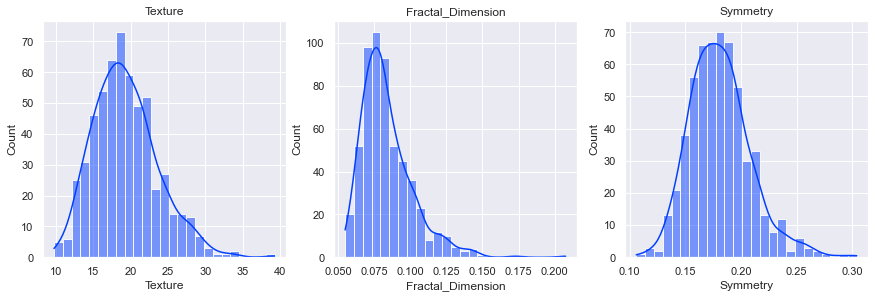

In [62]:
plt.figure(figsize=(20,20))
plot_number = 0

for feature_name in df.columns:
    plot_number += 1
    plt.subplot(4,4, plot_number)
    sns.histplot(data=piece_data[feature_name], bins=n, kde=True,palette ='bright' )
    plt.title(feature_name)

plt.show()

In [63]:
def box_plot(column):
    q = [0.1, 0.25, 0.5, 0.75, 0.9]
    quants = column.quantile(q=q)
    figure, ax = plt.subplots(1, 1, figsize=(10, 3))
    
    boxplot = sns.boxplot(column, ax=ax, linewidth=0.5)
    
    for quant in quants:
        ax.axvline(quant, color='black', linestyle='--', alpha=0.5)
        
    plt.title(column.name)
    plt.show()


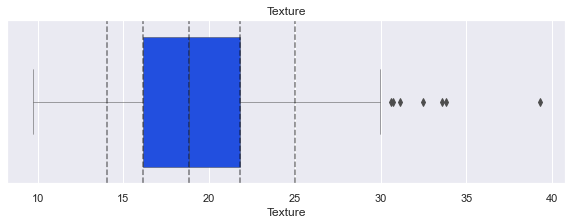

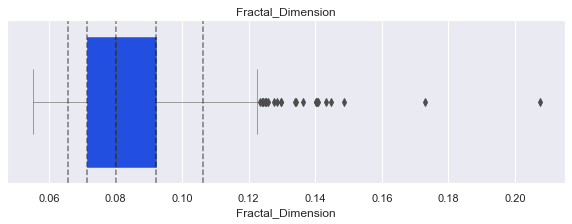

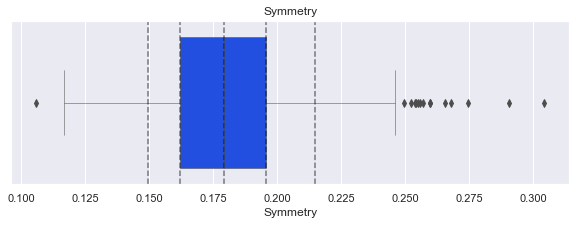

In [64]:
for column in list(df.columns):
    quants, col_min,col_max = order_statistic(df[column])
    box_plot(df[column])

In [65]:
df.Symmetry.describe()

count    569.000000
mean       0.181162
std        0.027414
min        0.106000
25%        0.161900
50%        0.179200
75%        0.195700
max        0.304000
Name: Symmetry, dtype: float64

In [66]:
for column in df:
    print(column)
    print(df[column].describe())
    print("")

Texture
count    569.000000
mean      19.289649
std        4.301036
min        9.710000
25%       16.170000
50%       18.840000
75%       21.800000
max       39.280000
Name: Texture, dtype: float64

Fractal_Dimension
count    569.000000
mean       0.083946
std        0.018061
min        0.055040
25%        0.071460
50%        0.080040
75%        0.092080
max        0.207500
Name: Fractal_Dimension, dtype: float64

Symmetry
count    569.000000
mean       0.181162
std        0.027414
min        0.106000
25%        0.161900
50%        0.179200
75%        0.195700
max        0.304000
Name: Symmetry, dtype: float64



In [67]:
def cut_tails(column):
    box_quantiles = column.quantile([0.25, 0.75])
    box_len = box_quantiles.diff().dropna().item()

    bounds = box_quantiles + 1.5 * np.array([-box_len, box_len])
    min_bound, max_bound = bounds.values.round(5)
    
    filt = ((column > min_bound) & (column < max_bound))
    return column[filt]

In [110]:
# df['Symmetry'] = cut_tails(df['Symmetry'])
# df['Texture'] = cut_tails(df['Texture'])
df['Fractal_Dimension'] = cut_tails(df['Fractal_Dimension'])

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Texture            562 non-null    float64
 1   Fractal_Dimension  545 non-null    float64
 2   Symmetry           554 non-null    float64
dtypes: float64(3)
memory usage: 13.5 KB


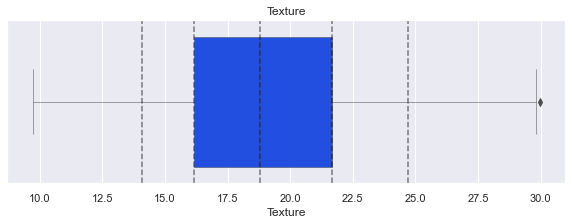

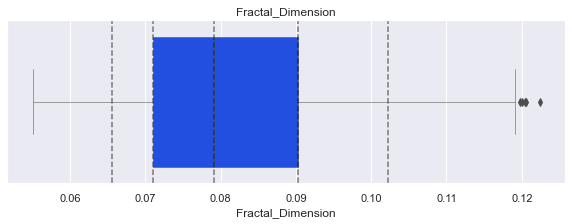

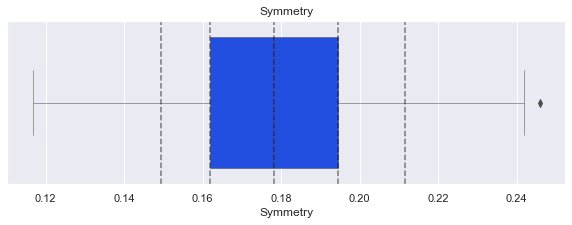

In [70]:
for column in list(df.columns):
    quants, col_min,col_max = order_statistic(df[column])
    box_plot(df[column])

In [82]:
def draw_dists(column,dists):
    
    figure, ax = plt.subplots(1, 1, figsize=(10, 5))
    subplot = sns.histplot(column, kde=False, stat='density',bins=n,color = '#ADD8E6')
      
    x = np.linspace(np.min(column), np.max(column), 100)
    
    for dist in dists:
        name = type(dist).__name__
        res = dist.fit(column)
        print("Dist: ",name, "val:", res)
        y = dist.pdf(x, *res)
        sns.lineplot(x, y, label=name)
        
    plt.legend()

Dist:  norm_gen val: (19.289648506151146, 4.297254637090421)
Dist:  beta_gen val: (10.014856681234333, 8532173.088431023, 5.694131662885545, 11582492.057548802)
Dist:  logistic_gen val: (19.052172375532436, 2.415511858892927)


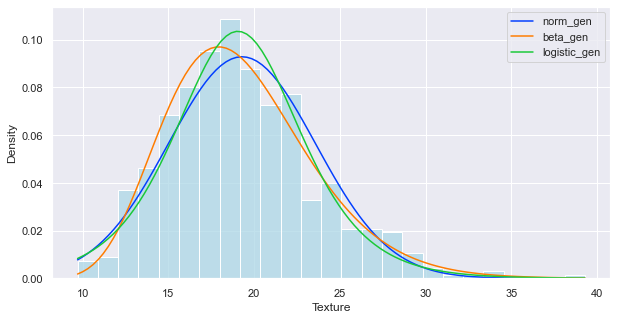

In [83]:
dists = [scipy.stats.norm,scipy.stats.beta,scipy.stats.logistic] 
draw_dists(piece_data.Texture,dists)

Dist:  alpha_gen val: (4.576691390690346, 0.013729756503105494, 0.30437671063782945)
Dist:  t_gen val: (3.7866333823777403, 0.08084075737091362, 0.012725262985552587)
Dist:  chi2_gen val: (6.382948364414851, 0.05316192972686132, 0.00482283869316099)


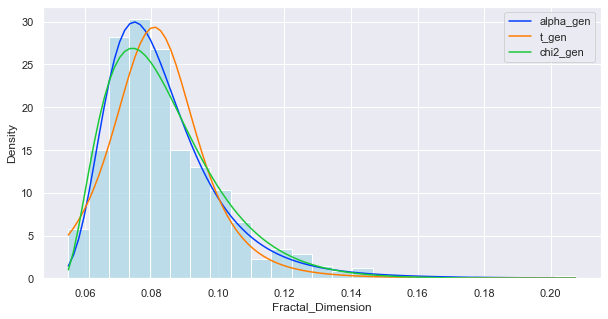

In [84]:
dists = [scipy.stats.alpha,scipy.stats.t,scipy.stats.chi2]
draw_dists(piece_data.Fractal_Dimension,dists)

Dist:  norm_gen val: (0.18116186291739894, 0.02739018086426853)
Dist:  beta_gen val: (14.436428163541239, 3308490.3304565074, 0.07741254825089552, 23784.954200206954)
Dist:  logistic_gen val: (0.17964002085115985, 0.015099974697503375)


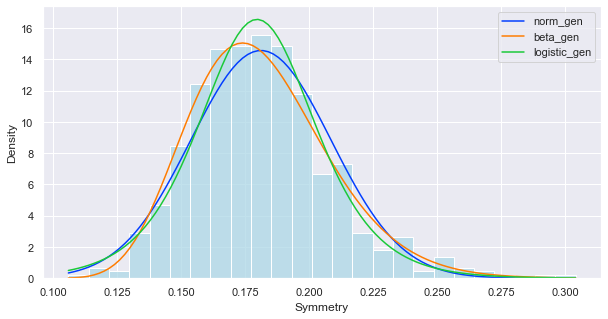

In [85]:
dists = [scipy.stats.norm,scipy.stats.beta,scipy.stats.logistic] 
draw_dists(piece_data.Symmetry,dists)

In [277]:
print('Texture')
dists(df.Texture,scipy.stats.beta)
print()
print('Fractal_Dimension')
dists(df.Fractal_Dimension,scipy.stats.alpha)
print()
print('Symmetry')
dists(df.Symmetry,scipy.stats.beta)

Texture
MLE beta_gen: 10.014856681234333, 8532173.088431023
MSE beta_gen: [1.02959872e+01 8.53217309e+06 5.33617549e+00 1.15824921e+07]

Fractal_Dimension
MLE alpha_gen: 4.576691390690346, 0.013729756503105494
MSE alpha_gen: [4.57545546 0.01217724 0.31194283]

Symmetry
MLE beta_gen: 14.436428163541239, 3308490.3304565074
MSE beta_gen: [1.28608729e+01 3.30849033e+06 8.82967107e-02 2.37849523e+04]


In [98]:
texture_best_params_beta = [1.02959867e+01, 8.53217309e+06, 5.33617611e+00, 1.15824921e+07]
fractal_dimension_best_params_alpha = [4.57545546, 0.01217724, 0.31194283]
symmetry_best_params_beta = [1.28608726e+01, 3.30849033e+06, 8.82967128e-02, 2.37849523e+04]

In [99]:
def qq_plot(column,dist):
    
    figure, ax = plt.subplots(1, 1, figsize=(5, 5))

    res = dist.fit(column)
    scipy.stats.probplot(column, dist=dist, sparams=res, plot=ax)

    ax.get_lines()[0].set_marker('o')
    ax.get_lines()[0].set_color('blue')
    ax.get_lines()[1].set_ls('--')
    ax.get_lines()[1].set_color('black')
    ax.get_lines()[1].set_linewidth(0.75)
    plt.show()

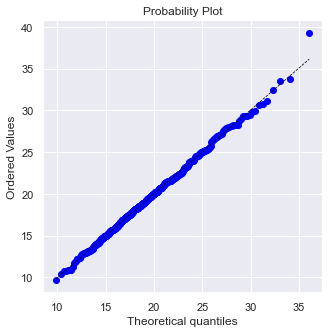

In [100]:
qq_plot(piece_data.Texture,scipy.stats.beta)

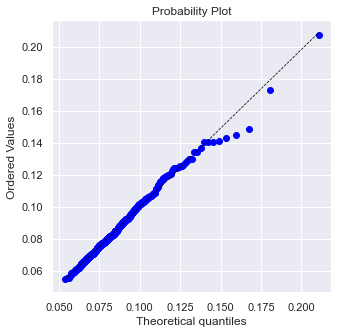

In [101]:
    qq_plot(piece_data.Fractal_Dimension,scipy.stats.alpha)

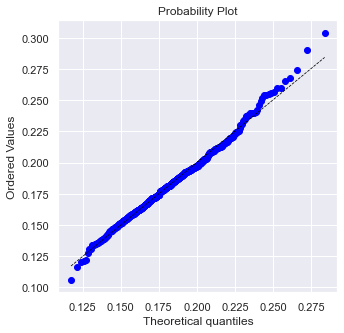

In [105]:
qq_plot(piece_data.Symmetry,scipy.stats.beta)

In [106]:
def testing_ktest(column,dist,dist_name,params):
    
    params = dist.fit(column)
    ks = scipy.stats.kstest(column, dist_name, params, N=100)
    print(ks)
    
    
def testing_by_tt(column,dist,param):
    
    val_quants = np.linspace(0,1,500)[1:-1]
    
    a = column.quantile(val_quants).values
    b = dist(*param).ppf(val_quants)

    tt = scipy.stats.ttest_ind(a,b)
    print(tt)

In [108]:
print('Texture')
testing_ktest(piece_data.Texture,scipy.stats.beta,'beta',texture_best_params_beta)
testing_by_tt(piece_data.Texture,scipy.stats.beta, texture_best_params_beta)
print()
print('Fractal_Dimension')
testing_ktest(piece_data.Fractal_Dimension,scipy.stats.alpha,'alpha',fractal_dimension_best_params_alpha)
testing_by_tt(piece_data.Fractal_Dimension,scipy.stats.alpha, fractal_dimension_best_params_alpha)
print()
print('Symmetry beta')
testing_ktest(piece_data.Symmetry,scipy.stats.beta,'beta',symmetry_best_params_beta)
testing_by_tt(piece_data.Symmetry,scipy.stats.beta, symmetry_best_params_beta)

Texture
KstestResult(statistic=0.01938322666339909, pvalue=0.9803643481509621)
Ttest_indResult(statistic=-0.09213427041252112, pvalue=0.926622216154515)

Fractal_Dimension
KstestResult(statistic=0.02376369599019812, pvalue=0.8971407617987701)
Ttest_indResult(statistic=-0.20723097407869867, pvalue=0.8359000250340224)

Symmetry beta
KstestResult(statistic=0.03230686795906246, pvalue=0.5811311179717623)
Ttest_indResult(statistic=0.16927490437647869, pvalue=0.8656376579724049)


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Texture            569 non-null    float64
 1   Fractal_Dimension  569 non-null    float64
 2   Symmetry           569 non-null    float64
dtypes: float64(3)
memory usage: 13.5 KB


In [220]:
def cont_inverse_sampling(array, distribution):
    args = distribution.fit(array)
    print(args)
    x_array = np.random.rand(1000)
    inverse = distribution.ppf(x_array, *args)
    sns.histplot(array, kde=False, stat='density',color = 'r', label = 'distribution', bins=count_bins)
    sns.histplot(x=inverse,stat='density', label = 'sample',  alpha = 0.5, color = 'g', bins=30)
    plt.legend()


(10.014856681234333, 8532173.088431023, 5.694131662885545, 11582492.057548802)


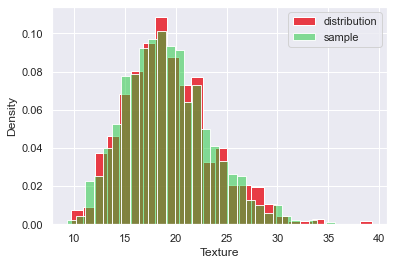

In [226]:
cont_inverse_sampling(df.Texture, scipy.stats.beta)

(4.576691390690346, 0.013729756503105494, 0.30437671063782945)


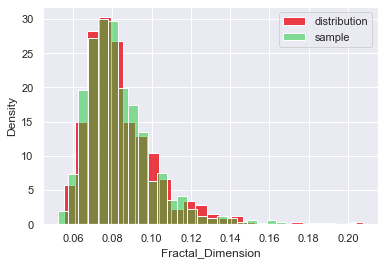

In [224]:
cont_inverse_sampling(df.Fractal_Dimension, scipy.stats.alpha)

(14.436428163541239, 3308490.3304565074, 0.07741254825089552, 23784.954200206954)


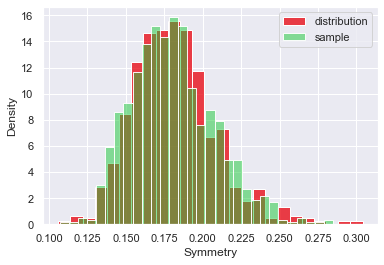

In [230]:
cont_inverse_sampling(df.Symmetry, scipy.stats.beta)

In [115]:
def select_disctr(array, distribution, params, M):
    x_plot = np.linspace(np.min(array), np.max(array), 100)
    g_vals = scipy.stats.norm.pdf(x_plot, *params)
    args = distribution.fit(array)
    y_plot = distribution.pdf(x_plot, *args)
    sns.lineplot(x_plot, y_plot, label=type(distribution).__name__)
    plt.plot(x_plot, M*g_vals, label='norm_gen')
    plt.legend()

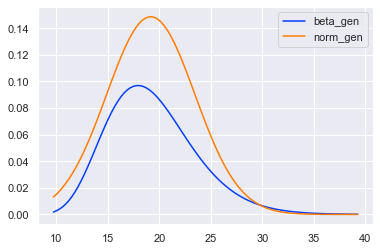

In [231]:
select_disctr(piece_data.Texture, scipy.stats.beta, [19.16824175,  4.29093123], 1.6)

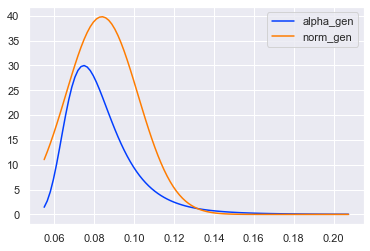

In [232]:
select_disctr(piece_data.Fractal_Dimension, scipy.stats.alpha, [0.08394581722319859, 0.018045389308594992], 1.8)

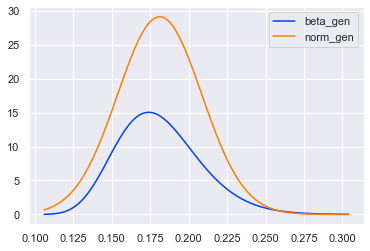

In [233]:
select_disctr(piece_data.Symmetry, scipy.stats.beta, [0.18116186291739894, 0.02739018086426853], 2)

In [259]:
def accept_reject(array, distribution, M, params):
    args = distribution.fit(array)
    samples = []
    N = 2000
    for _ in range(N):
        x = np.random.normal(*params)
        prob_accept = distribution.pdf(x, *args) / (M * scipy.stats.norm.pdf(x, *params))
        if np.random.random() < prob_accept:
            samples.append(x)
    sns.histplot(array, kde=False, stat='density',color = 'r', label = 'distribution', bins=count_bins)
    plt.hist(samples, density=True, label = 'sample', alpha = 0.5, color = 'g', bins=30)
    x_plot = np.linspace(np.min(array), np.max(array), 100)
    y_plot = distribution.pdf(x_plot, *args)
    plt.legend()
    


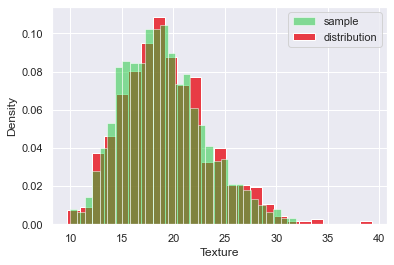

In [270]:
accept_reject(df.Texture, scipy.stats.beta, 1.6, [19.16824175,  4.29093123])

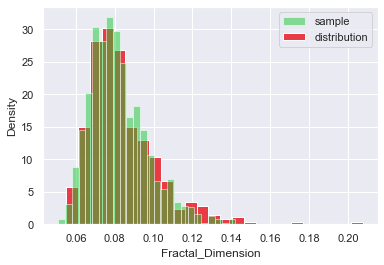

In [272]:
accept_reject(df.Fractal_Dimension, scipy.stats.alpha, 1.8, [0.08394581722319859, 0.018045389308594992])

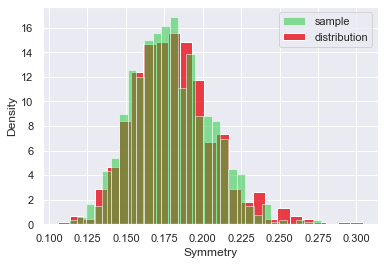

In [276]:
    accept_reject(piece_data.Symmetry, scipy.stats.beta, 2, [0.18116186291739894, 0.02739018086426853])